In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_SF3 = pd.read_csv( './data/SHARADAR_SF3_ce320d02f19d0b5d04c9557e0bc16680.zip') # read SF3 table
df_SF3 = df_SF3[df_SF3['securitytype'] == 'SHR']

In [3]:
#Read list of investors who invested less than 1,000 shares from 2013 to 2019.
df_investors = pd.read_csv('./data/Investor.csv', header=None, sep = '\t')
df_investors = df_investors.rename(columns = {0:'investorID', 1:'investorname'})

SF3_dates = pd.to_datetime(df_SF3.calendardate.unique()) # collect dates of investor filings
SF3_dates_rev = SF3_dates.values[::-1]

for t in range(len(SF3_dates_rev)-1):    
    print('t=',t)
    #Holdings in quater t and t+1 respectively
    prevHoldings = df_SF3.query('calendardate == "{}"'.format(str(SF3_dates_rev[t])[:10]))[['investorname', 'ticker', 'units', 'price']]
    prevHoldings = pd.merge(prevHoldings, df_investors)[['investorID', 'ticker', 'units', 'price']]
    prevHoldings = prevHoldings[prevHoldings['price'] > 0]
    currHoldings = df_SF3.query('calendardate == "{}"'.format(str(SF3_dates_rev[t+1])[:10]))[['investorname', 'ticker', 'units', 'price']]
    currHoldings = pd.merge(currHoldings, df_investors)[['investorID', 'ticker', 'units', 'price']]
    currHoldings = currHoldings[currHoldings['price'] > 0]
    
    #Holdings in quater t+1 but not in t
    newHoldings = currHoldings.merge(prevHoldings, on=['investorID', 'ticker'], how='left')
    newHoldings = newHoldings[newHoldings.units_y.isnull()][['investorID','ticker', 'units_x', 'price_x']]
    newHoldings['period'] = t+1
    newHoldings['value'] = newHoldings['units_x'] * newHoldings['price_x'] 
    newHoldings = newHoldings[['investorID', 'ticker', 'period', 'value']]
        
    #Holdings both in quater t and t+1
    diffHoldings = currHoldings.merge(prevHoldings, on=['investorID', 'ticker'], how='left')
    diffHoldings = diffHoldings[diffHoldings.units_y.notnull()][['investorID','ticker', 'units_x', 'price_x', 'units_y', 'price_y']]
    
    #Eliminate tickers which did consolidation/splitting shares (or doughtful data which changed 10+ times) in quater t+1
    diffHoldings = diffHoldings[~(((diffHoldings['units_y']/diffHoldings['units_x']>4)&(diffHoldings['price_x']/diffHoldings['price_y']>4))|((diffHoldings['units_x']/diffHoldings['units_y']>4)&(diffHoldings['price_y']/diffHoldings['price_x']>4))|((diffHoldings['price_x']/diffHoldings['price_y']>10)|(diffHoldings['price_x']/diffHoldings['price_y']>10)))]

    #Only keep the holding information which increases units
    diffHoldings['units'] = diffHoldings['units_x'] - diffHoldings['units_y']
    diffHoldings = diffHoldings[diffHoldings['units'] > 0]
    diffHoldings['value'] = diffHoldings['price_x'] * diffHoldings['units'] 
    diffHoldings['period'] = t+1
    diffHoldings = diffHoldings[['investorID', 'ticker', 'period', 'value']]
    
    newInvests = pd.concat([newHoldings, diffHoldings])
    
    #Set investor-weight as 1 devided by sqare root of number of stocks invested by the investor  
    investor_weights = pd.DataFrame(newInvests["investorID"].value_counts())
    investor_weights["investorID"] = 1 / (np.sqrt(investor_weights["investorID"]))
    investor_weights = investor_weights.rename(columns = {'investorID':'investor_weight'})
    investor_weights["investorID"] = investor_weights.index

    #Set stock-weight as 1 devided by sqare root of number of investors who invested to the stock  
    stock_weights = pd.DataFrame(newInvests["ticker"].value_counts())
    stock_weights["ticker"] = 1 / (np.sqrt(stock_weights["ticker"]))
    stock_weights = stock_weights.rename(columns = {'ticker':'stock_weight'})
    stock_weights["ticker"] = stock_weights.index

    newInvests = newInvests.merge(investor_weights, on=['investorID'], how='left')
    newInvests = newInvests.merge(stock_weights, on=['ticker'], how='left')
    #Set weight by multiplying investor-weight, stock-weight and log of value of investment
    newInvests['weight'] = newInvests['investor_weight'] * newInvests['stock_weight'] * np.log(newInvests['value'])
    newInvests = newInvests[['investorID', 'ticker', 'period', 'weight']]
    if t == 0:
        accmNewInvests = newInvests
    else:
        accmNewInvests = pd.concat([accmNewInvests, newInvests])

t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17
t= 18
t= 19
t= 20
t= 21
t= 22
t= 23
t= 24


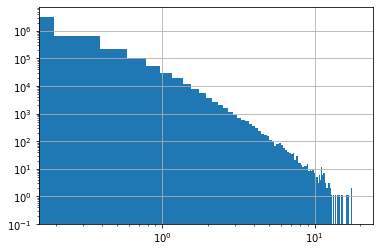

In [4]:
#Plot for weight of investor-investor pair and its counts
fig, ax = plt.subplots()
accmNewInvests["weight"].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
ax.set_xscale('log')

In [5]:
df_SF3_features = pd.read_csv( './data/SHARADAR_SF1.csv') # read feature table
df_SF3_features.head()

,ticker,dimension,calendardate,pe,pe1,pb,currentratio,divyield,payoutratio
0,A,MRQ,3/31/2013,14.202,14.192,2.712,2.525,0.010,0.250
1,A,MRQ,6/30/2013,16.427,16.445,3.219,2.957,0.010,0.240
2,A,MRQ,9/30/2013,22.876,23.609,3.177,3.110,0.009,0.182
3,A,MRQ,12/31/2013,25.726,26.076,3.544,3.275,0.008,0.224
4,A,MRQ,3/31/2014,24.921,24.903,3.203,3.128,0.009,0.314


In [6]:
SF3_features_dates = df_SF3_features.calendardate.unique()

In [7]:
#convert column 'calendardate' to 'period(number starting from 0(initial quater of the dataset))' so that features can concatenate with edge list by 'period'
for i in range(len(SF3_features_dates)):
    df_SF3_features_temp = df_SF3_features[df_SF3_features['calendardate'] == SF3_features_dates[i]]
    df_SF3_features_temp['period'] = i - 1
    df_SF3_features_temp = df_SF3_features_temp[['ticker', 'period', 'pe', 'pe1', 'pb', 'currentratio', 'divyield', 'payoutratio']]
    if i == 0:
        df_SF3_features_temp_aggr = df_SF3_features_temp
    else:
        df_SF3_features_temp_aggr = pd.concat([df_SF3_features_temp_aggr, df_SF3_features_temp])

/home/ann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
df_SF3_features_temp_aggr = df_SF3_features_temp_aggr[df_SF3_features_temp_aggr['period'] > 0]

In [9]:
accmNewInvests = accmNewInvests.merge(df_SF3_features_temp_aggr, on = ['ticker', 'period'])
accmNewInvests.head()

,investorID,ticker,period,weight,pe,pe1,pb,currentratio,divyield,payoutratio
0,984,CHK,1,0.140493,19.462,19.029,1.063,0.703,0.014,0.362
1,1288,CHK,1,0.060113,19.462,19.029,1.063,0.703,0.014,0.362
2,2523,CHK,1,0.078558,19.462,19.029,1.063,0.703,0.014,0.362
3,5117,CHK,1,0.116163,19.462,19.029,1.063,0.703,0.014,0.362
4,2307,CHK,1,0.112463,19.462,19.029,1.063,0.703,0.014,0.362


In [10]:
accmNewInvests = accmNewInvests[(accmNewInvests.pe.notnull())&(accmNewInvests.pe1.notnull())&(accmNewInvests.pb.notnull())]
accmNewInvests = accmNewInvests[(accmNewInvests.currentratio.notnull())&(accmNewInvests.divyield.notnull())&(accmNewInvests.payoutratio.notnull())]
accmNewInvests = accmNewInvests[accmNewInvests['weight'] > 0.0000001]

In [11]:
#add 'valueinvestor' column to accmNewInvests(1 if the investor is in valueinvestors' list and 0 if not)
valueinvestor = pd.read_csv('valueinvestorname.txt', names = {'investorname'})
valueinvestor = valueinvestor.append(df_investors[df_investors['investorname'].str.contains('VALUE')][['investorname']], ignore_index = True)
valueinvestor = valueinvestor.merge(df_investors, on = ['investorname'], how = 'left')
valueinvestor = valueinvestor[valueinvestor.investorID.notnull()]
valueinvestor = valueinvestor.astype({'investorID':'uint16'})
valueinvestor['valueinvestor'] = 1
valueinvestor = valueinvestor[['investorID', 'valueinvestor']]
accmNewInvests = accmNewInvests.merge(valueinvestor, on = ['investorID'], how = 'left')
accmNewInvests = accmNewInvests.fillna(0)[['investorID', 'ticker', 'period', 'weight', 'valueinvestor', 'pe', 'pe1', 'pb', 'currentratio', 'divyield', 'payoutratio']]
accmNewInvests.valueinvestor.sum()

33526.0

In [12]:
accmNewInvests.to_csv("./data/investments.csv", header=True, index=False, sep=",")
accmNewInvests.head()

,investorID,ticker,period,weight,valueinvestor,pe,pe1,pb,currentratio,divyield,payoutratio
0,984,CHK,1,0.140493,0.0,19.462,19.029,1.063,0.703,0.014,0.362
1,1288,CHK,1,0.060113,0.0,19.462,19.029,1.063,0.703,0.014,0.362
2,2523,CHK,1,0.078558,1.0,19.462,19.029,1.063,0.703,0.014,0.362
3,5117,CHK,1,0.116163,0.0,19.462,19.029,1.063,0.703,0.014,0.362
4,2307,CHK,1,0.112463,0.0,19.462,19.029,1.063,0.703,0.014,0.362


In [13]:
accmNewInvests_small = accmNewInvests[accmNewInvests['weight'] > 0.2]
accmNewInvests_small.to_csv("./data/investments_small.csv", header=True, index=False, sep=",")
accmNewInvests_small.shape

(700398, 11)